In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os
import json
import pandas as pd
import h3
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyproj import Transformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
from GNNEncoder import GNN
from PointerDecoder import PointerDecoder
import utils

In [3]:
path = '../almrrc2021/almrrc2021-data-evaluation/model_apply_inputs/'
path2 = '../almrrc2021/almrrc2021-data-evaluation/model_score_inputs/'

In [4]:
with open(path + 'eval_travel_times.json') as f:
  times = json.load(f)

In [5]:
with open(path2 + 'eval_actual_sequences.json') as f:
    actual = json.load(f)

In [6]:
with open("zone_dfs/labels_dict.json") as f:
    labels_dict = json.load(f)

In [7]:
def calculate_time(id_route, stop_list):
    total_time = 0
    for src, tgt in zip(stop_list[:-1], stop_list[1:]):
        total_time += times[id_route][src][tgt]
    return total_time

In [8]:
df = pd.read_parquet("../df_la_test.parquet")

In [9]:
df.loc[:, "h3_index"] = df.apply(lambda row: h3.latlng_to_cell(row["lat"], row["lng"], res=6), axis=1)
df.loc[:, "cluster"] = df.apply(lambda row: labels_dict.get(row["h3_index"], -1.0), axis=1)

In [10]:
grouped = df.groupby(by="route_id")

In [11]:
avoid_creating = False
if os.path.exists("graph_lists/graph_list_test_zone_def.pt"):
    graph_list = torch.load("graph_lists/graph_list_test_zone_def.pt", weights_only=False)
    avoid_creating = True
else:
    graph_list = []

all_zones = df["zone_id"].unique().tolist()

zone_encoder = LabelEncoder()
zone_encoder.fit(all_zones)

zone_coords = utils.calculate_zone_coords(df)
zone_embedding = utils.init_zone_embeddings(zone_encoder, zone_coords)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

stops_idx = {}

for route_id, route in grouped:
    stops_idx[route_id] = {i : stop for i, stop in enumerate(route.stop_id)}
    if avoid_creating:
        continue

    idx_stops = {stop: i for i, stop in enumerate(route.stop_id)}
    coords_dict = route.set_index("stop_id")[["lat", "lng"]].to_dict("index")

    route_graphs = []
    for cluster in route["cluster"].unique():
        subroute = route[route["cluster"] == cluster]

        if subroute.empty:
            continue

        local_to_global = {}
        for i, stop in enumerate(subroute["stop_id"]):
            local_to_global[i] = idx_stops[stop]
        
        idx_local = {stop: i for i, stop in enumerate(subroute.stop_id)}

        centroid_lat, centroid_lng = utils.calculate_route_centroid(subroute)
        centroid_x, centroid_y = transformer.transform(centroid_lng, centroid_lat)
        centroid = torch.tensor([centroid_x, centroid_y], dtype=torch.float)

        coords = torch.tensor(subroute[["lat", "lng"]].values, dtype=torch.float)
        coords_zs = utils.zscore(coords)
        positional_encodings = utils.positional_encoding(coords_zs)
        pe_tensor = torch.tensor(positional_encodings, dtype=torch.float)

        zone_ids = zone_encoder.transform(subroute["zone_id"])
        zone_ids = torch.tensor(zone_ids, dtype=torch.long)
        with torch.no_grad():
            zone_vectors = zone_embedding(zone_ids)

        lats = coords[:, 0].numpy()
        lngs = coords[:, 1].numpy()

        xs, ys = transformer.transform(lngs, lats)
        xy_coords = torch.tensor(list(zip(xs, ys)), dtype=torch.float)

        dist_to_centroid = torch.norm(xy_coords - centroid, dim=1).unsqueeze(1)

        x = torch.cat([pe_tensor, zone_vectors, dist_to_centroid], dim=1)

        edges = []
        edge_weights = []


        projected_coords = {
            stop_id: transformer.transform(stop["lng"], stop["lat"])
            for stop_id, stop in coords_dict.items()
        }

        dist_extremes_list = []
        if len(subroute) == 1:
            dist_extremes_list.append([0, 0])
        else:
            for i, stop in enumerate(subroute.stop_id):
                d = times[route_id][stop]
                d = {k: v for k, v in d.items() if k in subroute["stop_id"].values and k != stop}
                min_dist = min(d.values())
                max_dist = max(d.values())
                dist_extremes_list.append([min_dist, max_dist])
                for stop2 in d.keys():
                    if stop != stop2:
                        edges.append([i, idx_local[stop2]])
                        # x1, y1 = projected_coords[stop]
                        # x2, y2 = projected_coords[stop2]
                        # dist = np.hypot(x2 - x1, y2 - y1)  # Distance between stops              
                        edge_weights.append([d[stop2]])

        dist_extremes = torch.tensor(dist_extremes_list, dtype=torch.float)
        x = torch.cat([x, dist_extremes], dim=1)

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_weights, dtype=torch.float)

        route_graphs.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, local_to_global=local_to_global, idx_local=idx_local, cluster=cluster))

    start = route[route["type"] == "Station"].iloc[0]["stop_id"]
    start = idx_stops[start]

    graph_list.append(Data(graphs=route_graphs, route_id=route_id, start=start))


if not os.path.exists("graph_lists/graph_list_test_zone_def.pt"):
    torch.save(graph_list, "graph_lists/graph_list_test_zone_def.pt")

In [15]:
encoders = []
decoders = []

for i in range(57):
    encoder = GNN(node_features=35, edge_features=1, hidden_channels=128, heads=4)
    decoder = PointerDecoder(128)
    checkpoint = torch.load(f"zone_results/best_checkpoint_{i}.pt", weights_only=False)
    encoder.load_state_dict(checkpoint["encoder_state_dict"])
    decoder.load_state_dict(checkpoint["decoder_state_dict"])
    encoder.eval()
    decoder.eval()
    encoders.append(encoder)
    decoders.append(decoder)

general_encoder = GNN(node_features=35, edge_features=1, hidden_channels=128, heads=4)
general_decoder = PointerDecoder(128)
checkpoint = torch.load("results/results_definitive/best_checkpoint.pt", weights_only=False)
general_encoder.load_state_dict(checkpoint["encoder_state_dict"])
general_decoder.load_state_dict(checkpoint["decoder_state_dict"])
general_encoder.eval()
general_decoder.eval()

PointerDecoder(
  (query_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (key_proj): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (rnn): GRU(128, 128)
  (hidden_init): Linear(in_features=128, out_features=128, bias=True)
)

In [ ]:
loader = DataLoader(graph_list, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)

encoder = None
decoder = None

times_pred = []
times_actual = []
times_dif = []
pred_tours = []
actual_tours = []
route_ids = []
inference_time = []

for route in tqdm(loader):
    with torch.no_grad():
        inf_time = 0
        route_id = route.route_id[0]
        route_time_dists = times[route_id]
        route_ids.append(route_id)
        start = route.start[0].item()
        start_code = stops_idx[route_id][start]
        start_cluster = df[(df["route_id"] == route_id) & (df["stop_id"] == start_code)]["cluster"].values[0]
        # stops_in_start_cluster = len(df[(df["route_id"] == route_id) & (df["cluster"] == start_cluster)])
        # if stops_in_start_cluster > 1:
        next_start = start_code
        next_cluster = start_cluster
        pred_route = []
        visited_clusters = []
        # else:
        #     sorted_dists = dict(sorted(route_time_dists[start_code].items(), key=lambda item: item[1]))
        #     next_start = list(sorted_dists.keys())[1]
        #     next_cluster = df[(df["route_id"] == route_id) & (df["stop_id"] == next_start)]["cluster"].values[0]
        #     pred_route = [start]
        #     visited_clusters = [start_cluster]
        # print(f"Route: {route_id}")
        # print(f"Subgraphs: {len(route.graphs[0])}")
        # print(f"Clusters: {df[(df["route_id"] == route_id) & (df["type"] != "Station")]["cluster"].unique()}")
        for _ in range(len(route.graphs[0])):
            # print(f"Next cluster is {next_cluster}")
            graph = None
            for subgraph in route.graphs[0]:
                # print(subgraph.cluster)
                if subgraph.cluster == next_cluster:
                    graph = subgraph
                    break
                    
            cluster = graph.cluster
            visited_clusters.append(cluster)
            # print(visited_clusters)

            idx_local = graph.idx_local
            next_start_idx = idx_local[next_start]
            
            start_inf = time.time()
            if len(graph.x) == 1:
                pred_subtour = [torch.tensor(next_start_idx)]
            elif len(graph.x) == 2:
                pred_subtour = [torch.tensor(next_start_idx), torch.tensor(0) if next_start_idx == 1 else torch.tensor(1)]
            else:
                if cluster == -1.0:
                    # checkpoint = torch.load("results/results_35nf_1ef_updateOnImprovement/best_checkpoint.pt", weights_only=False)
                    # checkpoint = torch.load("best_checkpoint.pt", weights_only=False)
                    encoder = general_encoder
                    decoder = general_decoder
                else:
                    # checkpoint = torch.load(f"z/one_results/best_checkpoint_{int(cluster)}.pt", weights_only=False)
                    encoder = encoders[int(cluster)]
                    decoder = decoders[int(cluster)]
                # encoder.eval()
                # decoder.eval()
                embeddings = encoder(graph.x, graph.edge_index, graph.edge_attr, graph.batch)
                pred_subtour, _ = decoder(embeddings, torch.tensor([next_start_idx]), torch.tensor([0] * len(graph.x)))
                pred_subtour = pred_subtour[0]
            end_inf = time.time()

            inf_time += (end_inf - start_inf)

            pred_route.extend([graph.local_to_global[s.item()] for s in pred_subtour])
            
            dists = route_time_dists[stops_idx[route_id][pred_route[-1]]]
            dists = {k: v for k, v in dists.items() if df[(df["route_id"] == route_id) & (df["stop_id"] == k)]["cluster"].values[0] not in visited_clusters}
            if len(dists) > 0:
                # print(dists)
                sorted_dists = dict(sorted(dists.items(), key=lambda item: item[1]))
                next_start = list(sorted_dists.keys())[0]
                next_cluster = df[(df["route_id"] == route_id) & (df["stop_id"] == next_start)]["cluster"].values[0]
        
        inference_time.append(inf_time)
        actual_route = df[df["route_id"] == route_id].sort_values(by="order")["stop_id"].tolist()         
        pred_route = [stops_idx[route_id][s] for s in pred_route]
        if set(actual_route) != set(pred_route):
            print(f"Route {route_id} has different stops set")
            break
        pred_tours.append(pred_route)
        actual_tours.append(actual_route)
        pred_time = calculate_time(route_id, pred_route)
        actual_time = calculate_time(route_id, actual_route)
        times_pred.append(pred_time)
        times_actual.append(actual_time)
        times_dif.append(pred_time - actual_time)

 13%|█▎        | 216/1626 [16:33<1:48:06,  4.60s/it]


KeyboardInterrupt: 

In [ ]:
with open("zone_times/inference_times.json", "w") as f:
    json.dump(inference_time, f)

In [ ]:
with open("zone_results/times_pred.json", "w") as f:
    json.dump(times_pred, f)

In [ ]:
with open("zone_results/times_actual.json", "w") as f:
    json.dump(times_actual, f)

In [ ]:
with open("zone_results/times_dif.json", "w") as f:
    json.dump(times_dif, f)

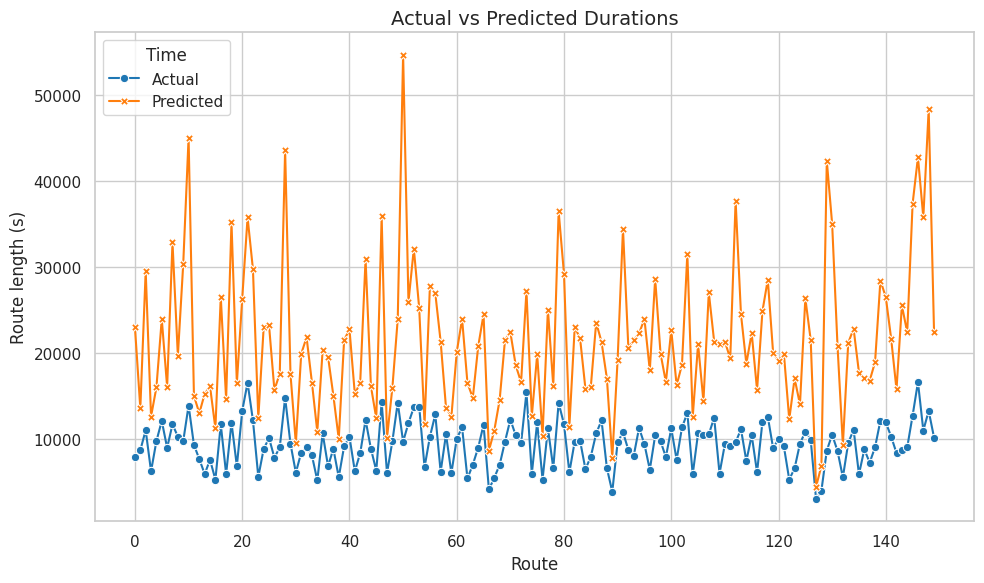

In [ ]:
sns.set_theme(style="whitegrid")

df_results = pd.DataFrame({
    'Index': list(range(150)) * 2,
    'Duration (s)': times_actual[:150] + times_pred[:150],
    'Time': ['Actual'] * 150 + ['Predicted'] * 150
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='Index', y='Duration (s)', hue='Time', style='Time',
             markers=True, dashes=False, palette=['#1f77b4', '#ff7f0e'])

plt.title('Actual vs Predicted Durations', fontsize=14)
plt.xlabel('Route')
plt.ylabel('Route length (s)')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
times_dif_arr = np.array(times_dif)
print(f"Avg error: {times_dif_arr.mean().item()}")
print(f"Median: {np.quantile(times_dif_arr, 0.5)}")
print(f"Quantile 0.25: {np.quantile(times_dif_arr, 0.25)}")
print(f"Quantile 0.75: {np.quantile(times_dif_arr, 0.75)}")
print(f"Quantile 0.9: {np.quantile(times_dif_arr, 0.9)}")
print(f"Quantile 0.95: {np.quantile(times_dif_arr, 0.95)}")
print(f"Quantile 0.99: {np.quantile(times_dif_arr, 0.99)}")
print(f"Max error: {times_dif_arr.max()}")
print(f"Min error: {times_dif_arr.min()}")
print(f"Route with max error: {np.argmax(times_dif_arr)}")
print(f"Route with min error: {np.argmin(times_dif_arr)}")

Avg error: 12535.179643296435
Median: 11501.450000000012
Quantile 0.25: 8061.125
Quantile 0.75: 15389.749999999996
Quantile 0.9: 20587.65
Quantile 0.95: 24462.475000000006
Quantile 0.99: 35352.27500000001
Max error: 53103.29999999998
Min error: 1278.400000000001
Route with max error: 1103
Route with min error: 1302


In [ ]:
print(f"Avg actual route length: {np.mean(times_actual)}")
print(f"Avg predicted route length: {np.mean(times_pred)}")

Avg actual route length: 9352.673985239851
Avg predicted route length: 21887.853628536286


In [ ]:
dif_percent = []

for pred, actual in zip(times_pred, times_actual):
    dif_percent.append((abs(actual - pred) / abs(actual)) * 100)

dif_percent_arr = np.array(dif_percent)
dif_percent_arr.mean().item()

133.83349622579527

In [ ]:
difs = []

for pred, actual in zip(times_pred, times_actual):
    dif = (actual - pred) ** 2
    difs.append(dif)

difs_arr = np.array(difs)
difs_arr.mean().item()

200090300.67566422

In [20]:
print(actual_tours[1103])
print(pred_tours[1103])

['NK', 'ME', 'WR', 'HO', 'BO', 'YF', 'HB', 'NX', 'CE', 'ZT', 'YT', 'IY', 'AF', 'KS', 'NT', 'TL', 'FZ', 'WA', 'PD', 'PE', 'OK', 'DN', 'IS', 'QD', 'GG', 'VR', 'CO', 'KE', 'EN', 'AK', 'GV', 'FR', 'KO', 'EB', 'NZ', 'XO', 'NU', 'WE', 'KN', 'FX', 'FJ', 'MH', 'HP', 'UM', 'FT', 'YJ', 'YX', 'PP', 'KL', 'TO', 'YY', 'AT', 'QY', 'CP', 'VV', 'SX', 'HG', 'SU', 'DB', 'GR', 'FO', 'DK', 'YE', 'GI', 'PG', 'IF', 'XC', 'GD', 'HT', 'XI', 'ET', 'KP', 'UL', 'IZ', 'JV', 'BV', 'EJ', 'FL', 'MW', 'NO', 'KH', 'JE', 'JM', 'VA', 'HH', 'WY', 'EP', 'NB', 'TE', 'CC', 'SL', 'UV', 'AQ', 'DW', 'KB', 'ZE', 'TS', 'RD', 'IT', 'FQ', 'YI', 'TY', 'VX', 'DR', 'AI', 'VF', 'FF', 'EF', 'QH', 'WW', 'OE', 'PC', 'SJ', 'OG', 'GT', 'ML', 'GK', 'LC', 'FW', 'RN', 'JP', 'HA', 'KR', 'WJ', 'ZI', 'SQ', 'PA', 'OR', 'LU', 'RY', 'TN', 'KC', 'KZ', 'PN', 'AM', 'XK', 'EI', 'KI', 'CL', 'BE', 'BZ', 'WN', 'HD', 'VW', 'QE', 'KQ', 'DQ', 'SB', 'JS', 'UO', 'HE', 'KV', 'BM', 'MU', 'HL', 'HM', 'XR', 'QU', 'HW', 'OL', 'CA', 'UG', 'OD', 'AB', 'PB', 'JF', 'SD

In [ ]:
df[(df["route_id"] == "RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e") & (df["type"] == "Station")]

In [ ]:
num_clusters = []

for route in route_ids:
    n_clusters = df[df["route_id"] == route]["cluster"].nunique()
    num_clusters.append(n_clusters)

In [ ]:
one_cluster = []
two_clusters = []
three_clusters = []
four_clusters = []
five_clusters = []

for n, t in zip(num_clusters, inference_time):
    if n == 1:
        one_cluster.append(t)
    elif n == 2:
        two_clusters.append(t)
    elif n == 3:
        three_clusters.append(t)
    elif n == 4:
        four_clusters.append(t)
    else:
        five_clusters.append(t)

In [30]:
time_one = np.mean(one_cluster)
time_two = np.mean(two_clusters)
time_three = np.mean(three_clusters)
time_four = np.mean(four_clusters)
time_five = np.mean(five_clusters)

print(f"One cluster: {time_one}")
print(f"Two cluster: {time_two}")
print(f"Three cluster: {time_three}")
print(f"Four cluster: {time_four}")
print(f"Five cluster: {time_five}")

One cluster: 2.603888764977455
Two cluster: 4.211353130666092
Three cluster: 6.648450777955251
Four cluster: 9.488745023042728
Five cluster: 13.351710557937622


In [ ]:
with open("inference_times_general.json", "r") as f:
    general_inference_times = json.load(f)

In [ ]:
general_avg = np.mean(general_inference_times)
general_avg

np.float64(0.17078146635386338)

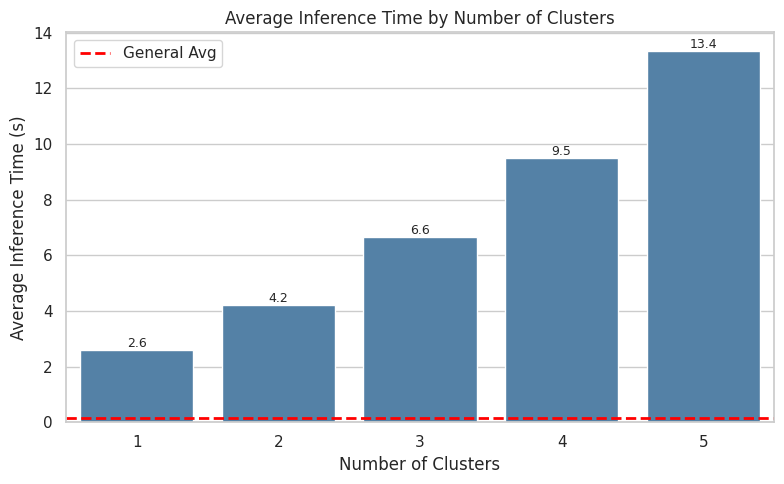

In [ ]:
df_avg_times = pd.DataFrame({
    'Clusters': [1, 2, 3, 4, 5],
    'Avg Duration (s)': [time_one, time_two, time_three, time_four, time_five]
})

# Estilo del gráfico
sns.set_theme(style="whitegrid")

# Crear figura
plt.figure(figsize=(8, 5))

# Gráfico de barras
ax = sns.barplot(data=df_avg_times, x='Clusters', y='Avg Duration (s)', color='steelblue')

plt.axhline(y=general_avg, color='red', linestyle='--', linewidth=2, label='General Avg')

# Añadir etiquetas sobre las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Etiquetas y título
ax.set_title('Average Inference Time by Number of Clusters')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Inference Time (s)')
plt.legend()
plt.tight_layout()
plt.show()